In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Bidirectional
import matplotlib.pyplot as plt

In [ ]:
df=pd.read_csv('preprocessed_data.csv')

In [ ]:
df.columns = df.columns.str.strip()

In [ ]:
df.head()

,Year,Company,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,...,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27,Feature28,Target 1,Target 2,Target 3
0,0.0,Hind. Unilever,0.042740,1.000000,1.000000,0.816058,0.991490,1.000000,0.504032,1.0,...,1.000000,1.000000,0.992685,1.000000,1.000000,0.515697,0.042114,0.520666,0.591245,0.620036
1,0.0,ITC,0.188153,0.915748,0.824484,0.775630,0.859654,0.000000,0.482527,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.647404,0.199529,0.219399,0.433190,0.424469
2,0.0,Wipro,0.225219,0.824896,1.000000,1.000000,1.000000,1.000000,0.762097,1.0,...,1.000000,0.487784,0.463120,0.454463,0.475678,0.418494,0.044785,1.000000,0.685042,0.789157
3,0.0,O N G C,0.105467,0.458576,0.447087,0.375252,0.397321,0.487660,0.649194,1.0,...,0.355742,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.378105,0.515936,0.831610
4,0.0,Lila Worldwide,0.422222,0.175416,0.231748,0.599227,0.290737,0.526773,0.462332,1.0,...,0.621761,0.354119,0.350489,0.353435,0.360627,0.656372,1.000000,1.000000,1.000000,0.600845


In [ ]:
df.isnull().sum()

,0
Year,0
Company,0
Feature1,0
Feature2,0
Feature3,0
Feature4,0
Feature5,0
Feature6,0
Feature7,0
Feature8,0


In [ ]:
df = df.sort_values(by="Year").reset_index(drop=True)

In [ ]:
le = LabelEncoder()
df["Company_encoded"] = le.fit_transform(df["Company"])


In [ ]:
def prepare_lstm_data(data, target_col, lookback=5):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[features].iloc[i-lookback:i].values)
        y.append(data[target_col].iloc[i])
    return np.array(X), np.array(y)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, TimeDistributed, RepeatVector

# Hyperparameters
time_steps = 10         # Number of historical years used as input
num_features = 28       # Number of features per year
n_future_steps = 5      # Number of years to predict growth for

# Define the model
inputs = Input(shape=(time_steps, num_features))

# Encoder - stacked LSTM (like downsampling path in UNet)
x = LSTM(128, return_sequences=True)(inputs)
x = LSTM(64)(x)

# Repeat vector for future steps (like upsampling in UNet)
x = RepeatVector(n_future_steps)(x)

# Decoder - stacked LSTM to output a sequence
x = LSTM(64, return_sequences=True)(x)
x = LSTM(32, return_sequences=True)(x)

# Final dense layer to output growth values
outputs = TimeDistributed(Dense(1))(x)

# Build and compile the model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 128)        │        80,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 5, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 5, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 5, 1)           │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,265 (684.63 KB)

 Trainable params: 175,265 (684.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
features = [f"Feature{i}" for i in range(1, 29)] + ["Company_encoded"]

In [ ]:
lookback = 5

In [ ]:
df = df.sort_values("Year")

In [ ]:
train_df = df[df["Year"] < 0.9].copy()  # You can change cutoff year
test_df = df[df["Year"] >= 0.9].copy()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])

In [ ]:
def prepare_lstm_data(data, target_col, lookback=5):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[features].iloc[i-lookback:i].values)
        y.append(data[target_col].iloc[i])
    return np.array(X), np.array(y)

In [ ]:
import numpy as np

def prepare_lstm_data(df, target_col, lookback, val_years=2, test_years=2):
    """
    Prepares train, val, test splits for LSTM from a time series DataFrame.
    Data is split company-wise, ordered by year to avoid leakage.
    """

    companies = df['Company'].unique()
    X_train_list, y_train_list = [], []
    X_val_list, y_val_list = [], []
    X_test_list, y_test_list = [], []

    for company in companies:
        company_df = df[df['Company'] == company].sort_values('Year').reset_index(drop=True)
        feature_cols = [col for col in company_df.columns if col not in ['Company', 'Year', target_col]]

        data = company_df[feature_cols].values
        target = company_df[[target_col]].values

        for i in range(lookback, len(company_df)):
            x_seq = data[i - lookback:i]
            y_seq = target[i]

            year = company_df.loc[i, 'Year']

            if i >= len(company_df) - test_years:
                X_test_list.append(x_seq)
                y_test_list.append(y_seq)
            elif i >= len(company_df) - (test_years + val_years):
                X_val_list.append(x_seq)
                y_val_list.append(y_seq)
            else:
                X_train_list.append(x_seq)
                y_train_list.append(y_seq)

    return (
        np.array(X_train_list), np.array(y_train_list),
        np.array(X_val_list), np.array(y_val_list),
        np.array(X_test_list), np.array(y_test_list)
    )


In [ ]:
def build_lstm_model(input_shape):
  inputs = Input(shape=input_shape)
  x = LSTM(128, return_sequences=True)(inputs)
  x = LSTM(64)(x)
  outputs = Dense(1)(x)
  model = Model(inputs, outputs)
  model.compile(optimizer='adam', loss='mse')
  return model

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Settings
lookback = 5  # Number of years used as input
target_col = 'Target 1'

# Prepare data
X_train, y_train, X_val, y_val, X_test, y_test = prepare_lstm_data(df, target_col, lookback)

# Build model
model = build_lstm_model(input_shape=X_train.shape[1:])

# Callbacks
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=10, min_lr=1e-6)
]

# Train model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

# Predict
predicted_growth = model.predict(X_test).reshape(-1)
y_test_flat = y_test.reshape(-1)

# Plot Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test_flat, label='Actual', marker='o')
plt.plot(predicted_growth, label='Predicted', marker='x')
plt.title(f'📈 Actual vs Predicted - {target_col}')
plt.xlabel('Time Step')
plt.ylabel('Growth')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# RMSE
rmse = mean_squared_error(y_test_flat, predicted_growth, squared=False)
print(f"📊 RMSE for {target_col}: {rmse:.4f}")


NameError: name 'prepare_lstm_data' is not defined

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Compute Mean Squared Error
mse = mean_squared_error(y_test_flat, predicted_growth)

# Compute RMSE manually
rmse = np.sqrt(mse)

# Compute RMSE as a percentage of the mean of the actual values
rmse_percentage = (rmse / np.mean(y_test_flat)) * 100

print(f"📊 RMSE for {target_col} as a percentage: {rmse_percentage:.2f}%")


📊 RMSE for Target 1 as a percentage: 28.88%


<ipython-input-41-566f883388e6>:9: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


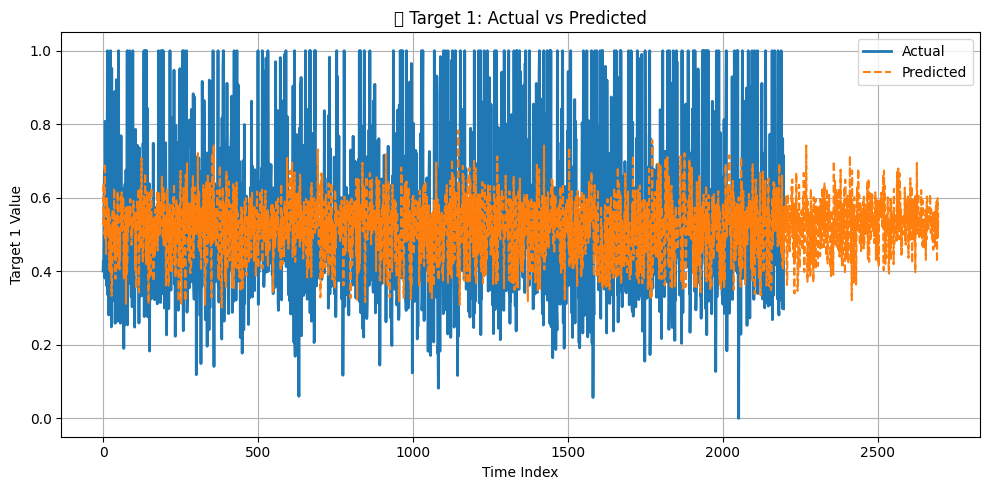

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_val, label='Actual', linewidth=2)
plt.plot(predicted_growth, label='Predicted', linestyle='--')
plt.title('📈 Target 1: Actual vs Predicted')
plt.xlabel('Time Index')
plt.ylabel('Target 1 Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

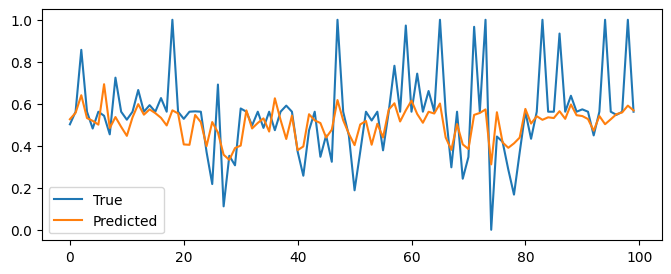

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(y_test[:100], label='True')
plt.plot(predicted_growth[:100], label='Predicted')
plt.legend()
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, predicted_growth))

# RMSE% (mean-based)
rmse_pct_mean = (rmse / np.mean(y_test)) * 100
rmse_pct_range = (rmse / (np.max(y_test) - np.min(y_test))) * 100

print(rmse_pct_mean)
print(rmse_pct_range)

28.884007407848905
15.61815150838552


# Second

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, GRU, Bidirectional, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv("preprocessed_data.csv")
df.columns = df.columns.str.strip()
df = df.sort_values(by="Year").reset_index(drop=True)

In [ ]:
# Encode Company
df["Company_encoded"] = LabelEncoder().fit_transform(df["Company"])

In [ ]:
# Normalize features
features = [f"Feature{i}" for i in range(1, 29)] + ["Company_encoded"]
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

In [ ]:
# Prepare LSTM-ready data
def prepare_lstm_data(data, target_col, lookback=5):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[features].iloc[i-lookback:i].values)
        y.append(data[target_col].iloc[i])
    return np.array(X), np.array(y)

In [ ]:
# Model builders
def build_stacked_lstm(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
def build_stacked_gru(input_shape):
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
def build_transformer_regressor(input_shape, num_heads=2, ff_dim=64):
    inputs = Input(shape=input_shape)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(inputs, inputs)
    x = LayerNormalization()(x)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
# Training loop
lookback = 5
EPOCHS = 10
BATCH_SIZE = 32


🧠 Training Stacked LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ Stacked LSTM RMSE for Target 3: 0.1523
📊 RMSE (% of mean): 24.95%
📊 RMSE (% of range): 15.62%


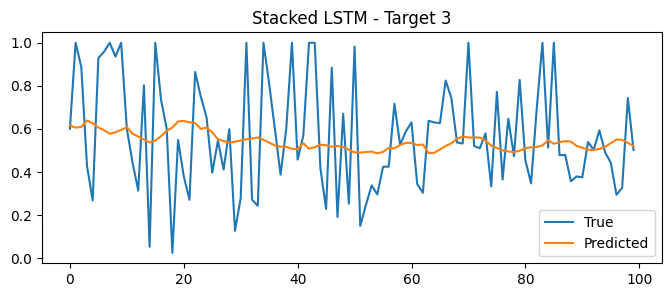


🧠 Training Stacked GRU model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ Stacked GRU RMSE for Target 3: 0.1648
📊 RMSE (% of mean): 27.00%
📊 RMSE (% of range): 16.90%


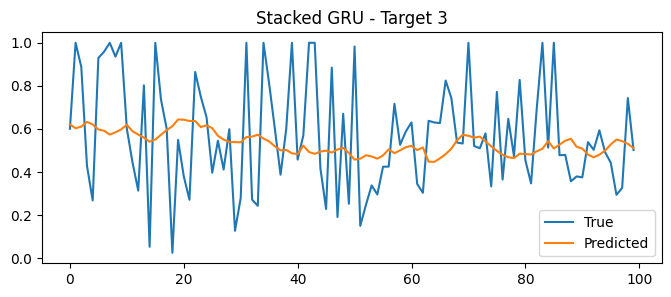


🧠 Training Transformer model...
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ Transformer RMSE for Target 3: 0.1301
📊 RMSE (% of mean): 21.31%
📊 RMSE (% of range): 13.34%


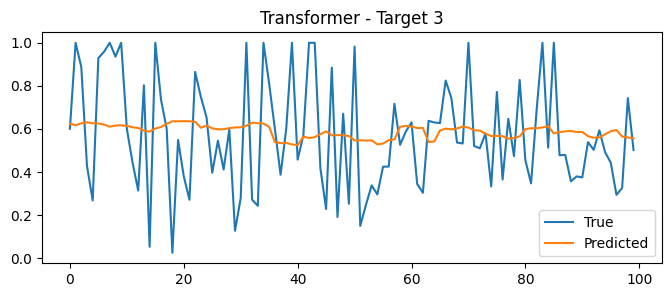

In [ ]:
# Store model performance
model_scores = []

for name, build_fn in {
    "Stacked LSTM": build_stacked_lstm,
    "Stacked GRU": build_stacked_gru,
    "Transformer": build_transformer_regressor
}.items():
    print(f"\n🧠 Training {name} model...")
    model = build_fn(X_train.shape[1:])
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop],
        verbose=0
    )

    y_pred = model.predict(X_test).flatten()
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # RMSE% (mean-based)
    rmse_pct_mean = (rmse / np.mean(y_test)) * 100
    rmse_pct_range = (rmse / (np.max(y_test) - np.min(y_test))) * 100

    # Store result
    model_scores.append({
        "Target": target_col,
        "Model": name,
        "RMSE": rmse,
        "RMSE% (mean)": rmse_pct_mean,
        "RMSE% (range)": rmse_pct_range
    })

    print(f"✅ {name} RMSE for {target_col}: {rmse:.4f}")
    print(f"📊 RMSE (% of mean): {rmse_pct_mean:.2f}%")
    print(f"📊 RMSE (% of range): {rmse_pct_range:.2f}%")

    # Plot predictions
    plt.figure(figsize=(8, 3))
    plt.plot(y_test[:100], label='True')
    plt.plot(y_pred[:100], label='Predicted')
    plt.title(f"{name} - {target_col}")
    plt.legend()
    plt.show()


In [ ]:
# Convert to DataFrame and rank
results_df = pd.DataFrame(model_scores)
print("\n🏆 Ranked Models by RMSE% (mean):")
print(results_df.sort_values(by="RMSE% (mean)").reset_index(drop=True))



🏆 Ranked Models by RMSE% (mean):
     Target         Model      RMSE  RMSE% (mean)  RMSE% (range)
0  Target 3   Transformer  0.130065     21.313025      13.341351
1  Target 3  Stacked LSTM  0.152261     24.950211      15.618127
2  Target 3   Stacked GRU  0.164797     27.004371      16.903973


# Third

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame after preprocessing
# Define your features (X) and target variable (y)
X = df.drop(['Target 1','Target 2','Target 3','Company','Year'], axis=1)
y1 = df['Target 1']
y2=df['Target 2']
y3=df['Target 3']

# Split the data into training and testing sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=42)
X3_train, X3_test, y3_train, y3_test = train_test_split(X, y3, test_size=0.2, random_state=42)

In [ ]:
# prompt: normalize the data to range(0,1)

from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

# Fit and transform the features (X)
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)

X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

X3_train_scaled = scaler.fit_transform(X3_train)
X3_test_scaled = scaler.transform(X3_test)


In [ ]:
#  Use MLP to train data of target 1

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train the MLPRegressor for 'Target 1'
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp_model.fit(X1_train_scaled, y1_train)

# Make predictions on the test set
y1_pred = mlp_model.predict(X1_test_scaled)

# Evaluate the model
mse = mean_squared_error(y1_test, y1_pred)
r2 = r2_score(y1_test, y1_pred)

print(f"Mean Squared Error (Target 1): {mse}")
print(f"Root Mean Squared Error (Target 1): {np.sqrt(mse)}")
print(f"R-squared (Target 1): {r2}")


Mean Squared Error (Target 1): 0.05178337669934266
Root Mean Squared Error (Target 1): 0.22755961130952623
R-squared (Target 1): -0.038182591051700854


In [ ]:
#  Use MLP to train data of target 2

# Initialize and train the MLPRegressor for 'Target 2'
mlp_model_target2 = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp_model_target2.fit(X2_train_scaled, y2_train)

# Make predictions on the test set for 'Target 2'
y2_pred = mlp_model_target2.predict(X2_test_scaled)

# Evaluate the model for 'Target 2'
mse_target2 = mean_squared_error(y2_test, y2_pred)
r2_target2 = r2_score(y2_test, y2_pred)

print(f"Mean Squared Error (Target 2): {mse_target2}")
print(f"Root Mean Squared Error (Target 2): {np.sqrt(mse_target2)}")
print(f"R-squared (Target 2): {r2_target2}")

Mean Squared Error (Target 2): 0.051594702251859664
Root Mean Squared Error (Target 2): 0.22714467251480863
R-squared (Target 2): 0.011576568318024894


In [ ]:
#  Use MLP to train data of target 3

# Initialize and train the MLPRegressor for 'Target 3'
mlp_model_target3 = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp_model_target3.fit(X3_train_scaled, y3_train)

# Make predictions on the test set for 'Target 3'
y3_pred = mlp_model_target3.predict(X3_test_scaled)

# Evaluate the model for 'Target 3'
mse_target3 = mean_squared_error(y3_test, y3_pred)
r2_target3 = r2_score(y3_test, y3_pred)

print(f"Mean Squared Error (Target 3): {mse_target3}")
print(f"Root Mean Squared Error (Target 3): {np.sqrt(mse_target3)}")
print(f"R-squared (Target 3): {r2_target3}")

Mean Squared Error (Target 3): 0.0601818479563841
Root Mean Squared Error (Target 3): 0.2453198890354879
R-squared (Target 3): -0.1200485713273336
